In this example we demonstrate how to create a gridded field from data on a section, for instance a set of profiles.

In [1]:
using DIVAnd
using DelimitedFiles
using PyPlot
const plt = PyPlot
using Interpolations
using Statistics

[ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d]
[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]


## Files and directories

In [2]:
datadir = "../data/"
datafile = joinpath(datadir, "data_SA02_CTD201506_v2.dat")
isfile(datafile) ? @debug("Already downloaded") : download("")

LoadError: RequestError: URL rejected: Malformed input to a URL function while requesting 

## Read and plot data 

In [3]:
data = readdlm(datafile, skipstart=1);
lon = data[:,1]
lat = data[:,2] 
dist = data[:,3]
pres = data[:,4] 
S = data[:,5] 
oxy = data[:,6];

### Plot salinity

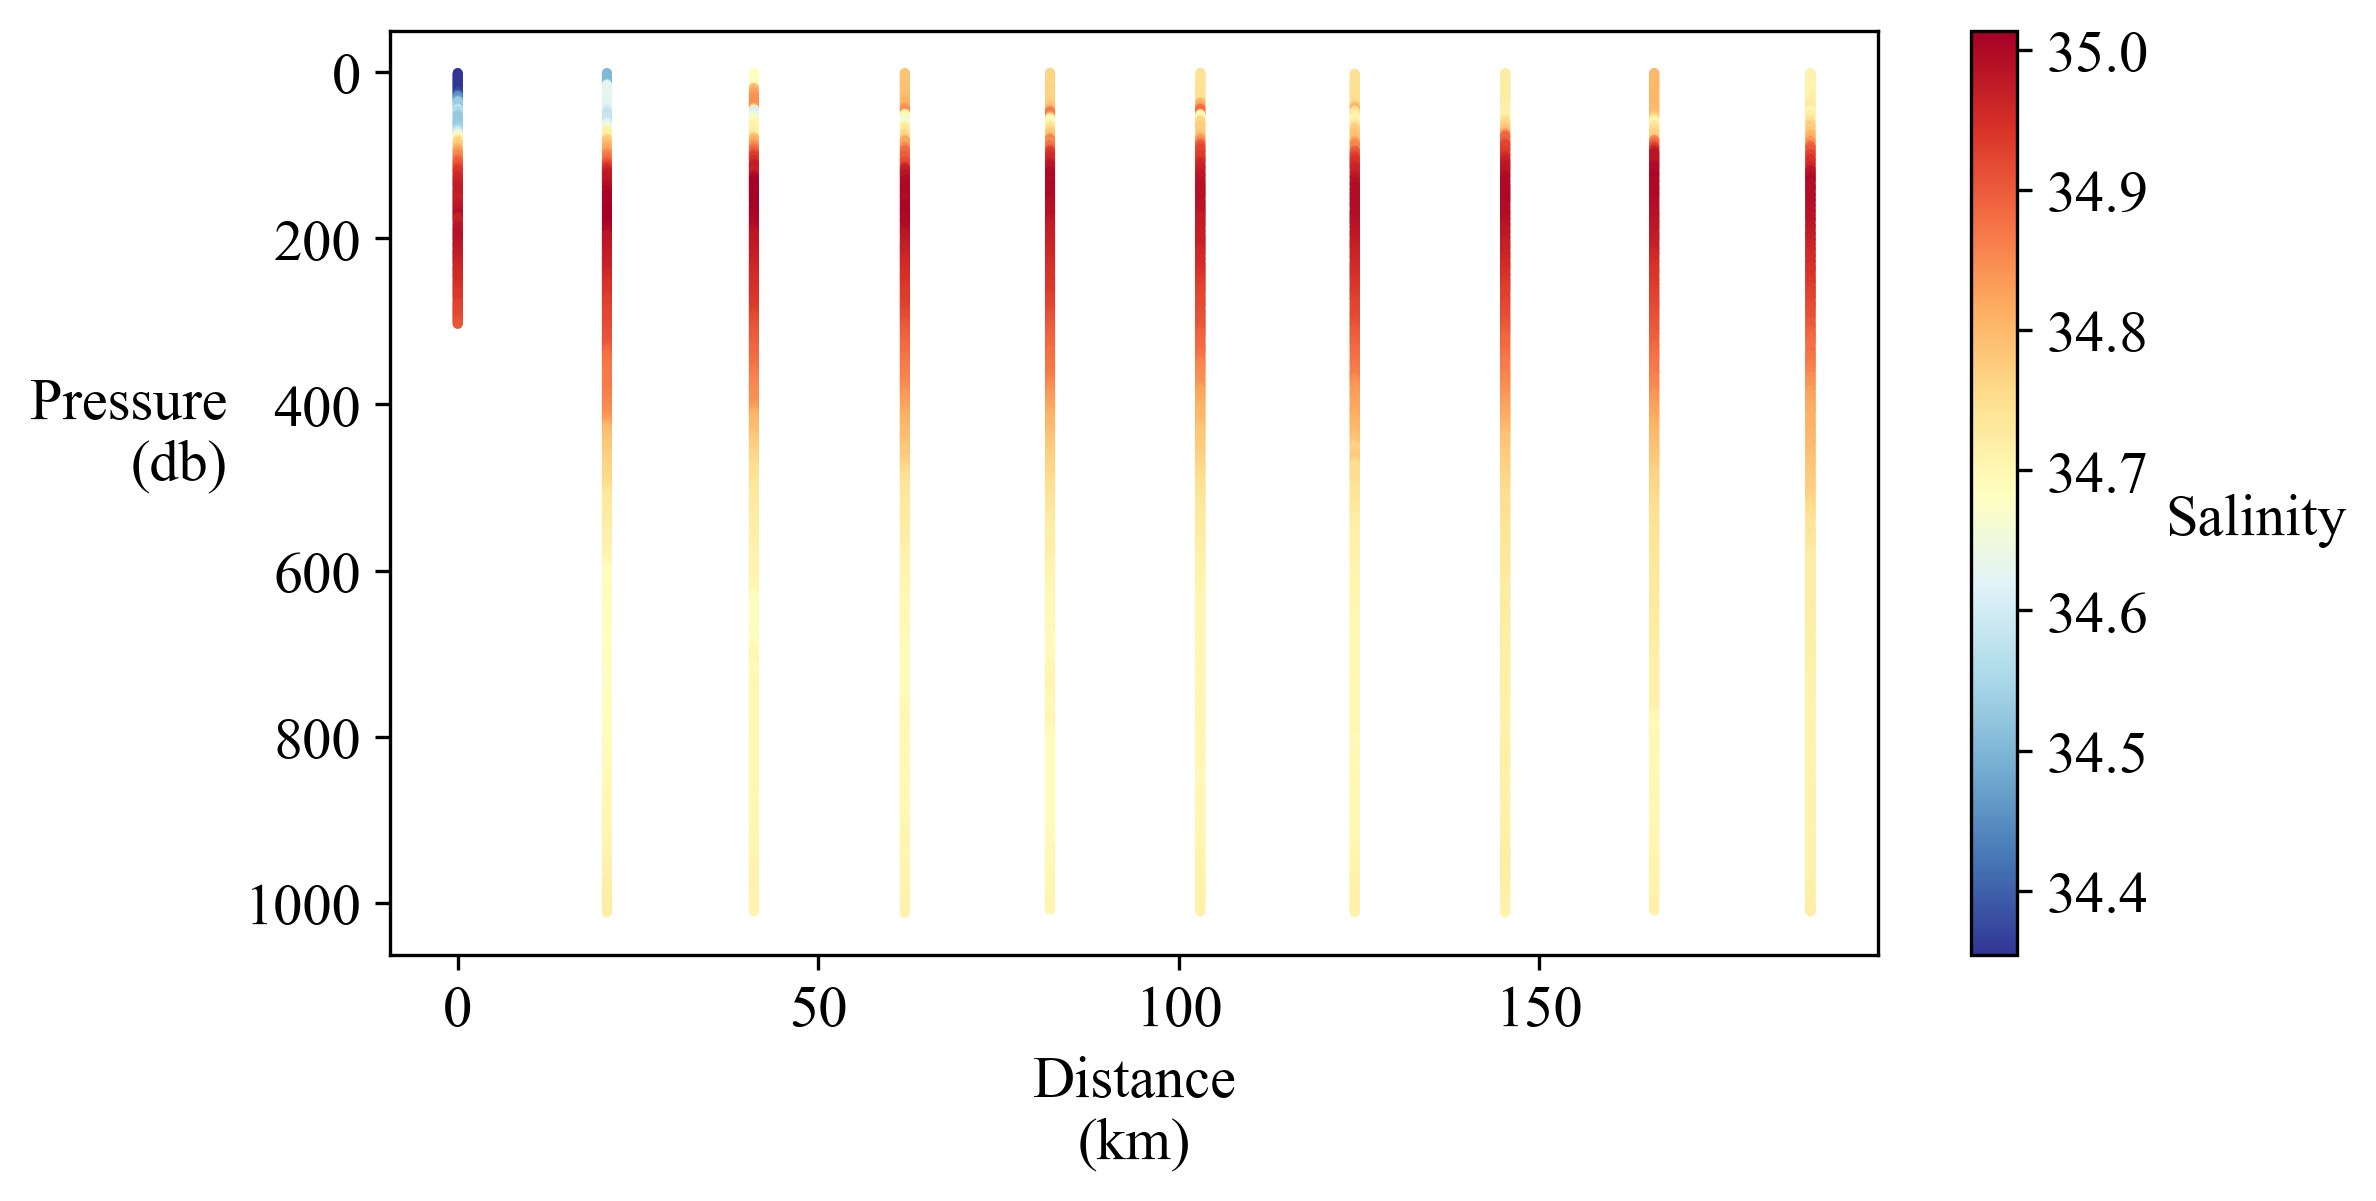

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
scat = ax.scatter(dist, pres, s=2, c=S, cmap=PyPlot.cm.RdYlBu_r)
cb = plt.colorbar(scat)
cb.set_label("Salinity", rotation=0, ha="left")
ax.set_xlabel("Distance\n(km)")
ax.set_ylabel("Pressure\n(db)", rotation=0, ha="right")
plt.gca().invert_yaxis()

## Extract and plot bathymetry
Its resolution is chosen according to the extension of the region of interest.

In [13]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
isfile(bathname) ? @info("Bathymetry file already downloaded") : download("https://dox.uliege.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)

┌ Info: Bathymetry file already downloaded
└ @ Main In[13]:2


We create a 2D grid for the bathymetry extraction: the goal is to know the bathymetry where we have the profiles, hence the original bathymetry has to be re-interpolated.

In [14]:
lonmin, lonmax, latmin, latmax = minimum(lon), maximum(lon), minimum(lat), maximum(lat)
Δlon = lonmax - lonmin;
Δlat = latmax - latmin;
xi = lonmin - 0.05 * Δlon :0.01: lonmax + 0.05 * Δlon
yi = latmin - 0.05 * Δlat :0.01: latmax + 0.05 * Δlat

bx, by, b = DIVAnd.extract_bath(bathname, true, xi, yi)

19.1423035:0.01:20.0323035

Plot the bathymetry and the data locations.

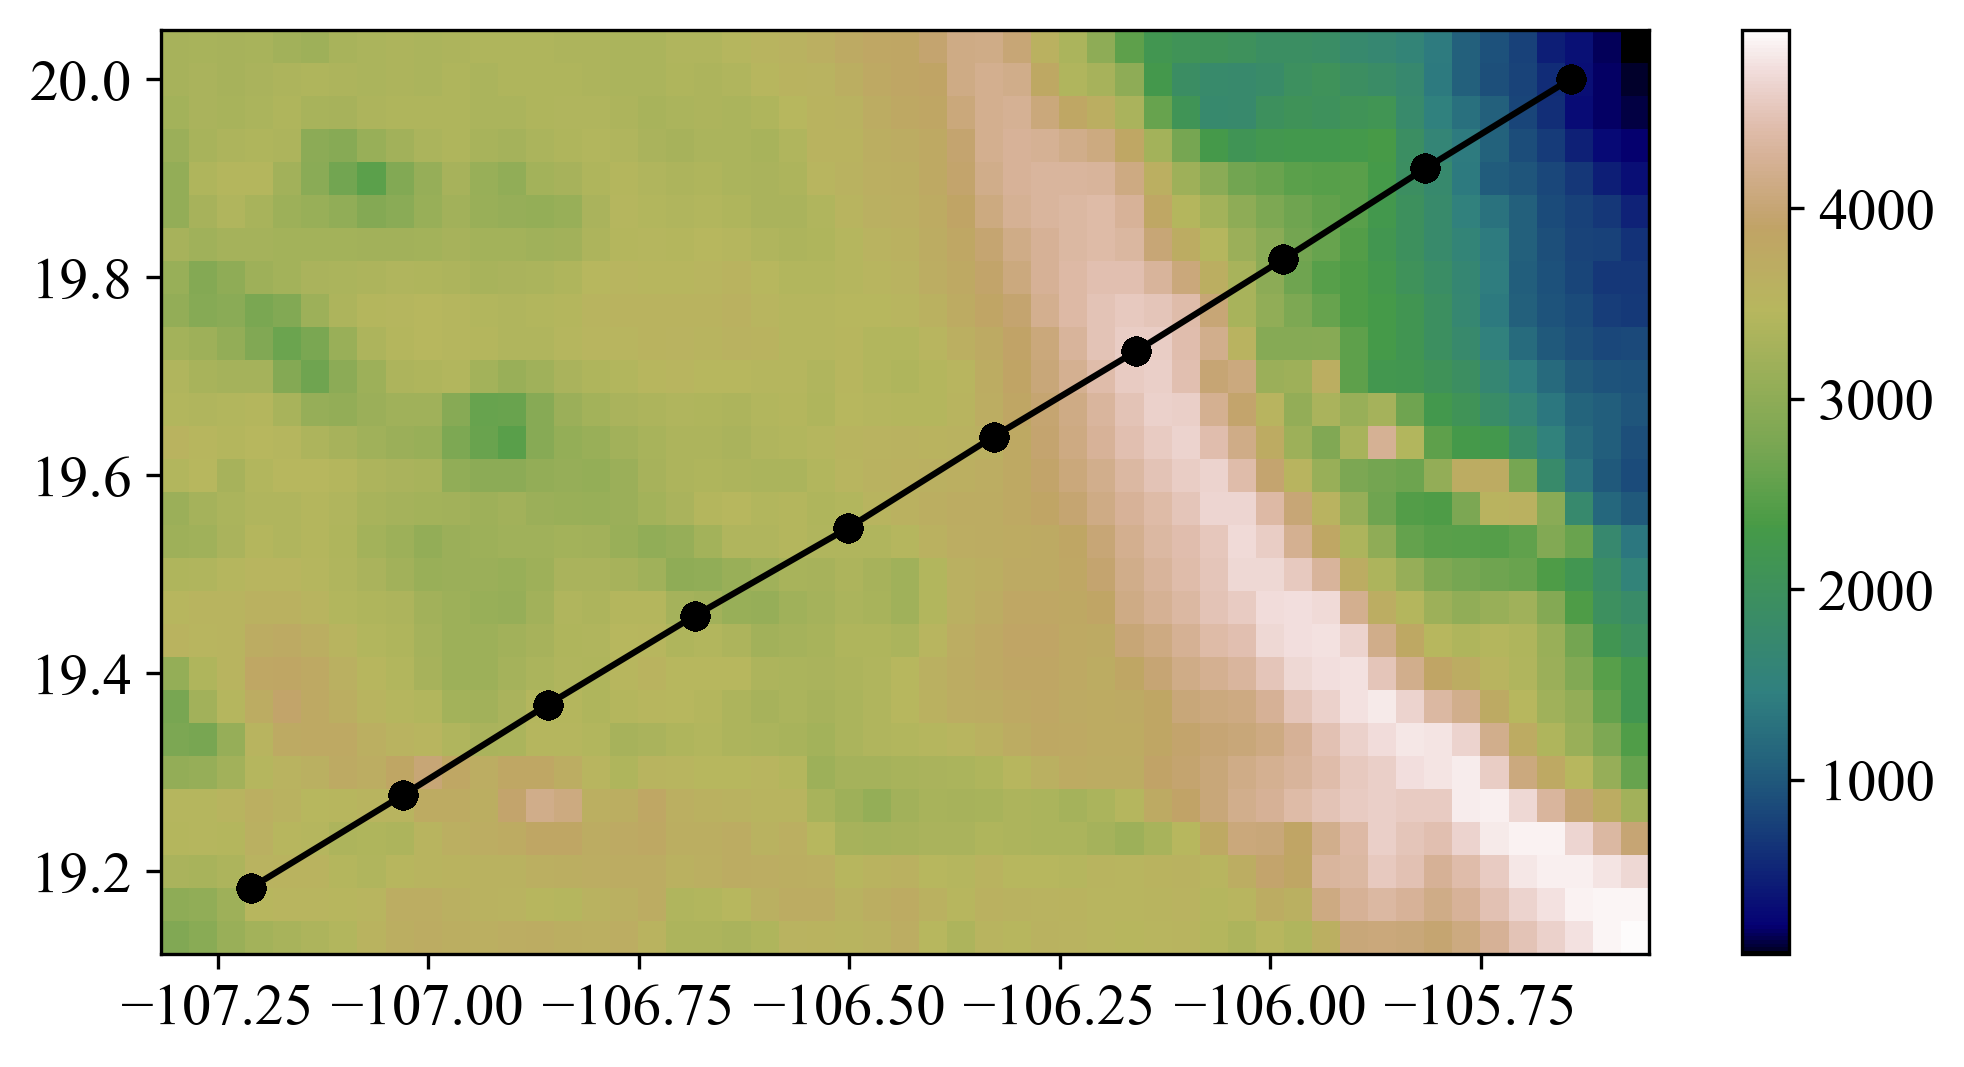

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6418b39c90>

In [20]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
pcm = ax.pcolormesh(bx, by, b', cmap=plt.cm.gist_earth)
ax.plot(lon, lat, "ko-")
plt.colorbar(pcm)

### Create the interpolator

In [18]:
lon_u, lat_u = unique(lon), unique(lat)
itp = Interpolations.interpolate((bx, by), b, Gridded(Linear()));
depth_interp = itp.(lon_u, lat_u);

Plot the interpolated depth over the bathymetry to see if they corespond.

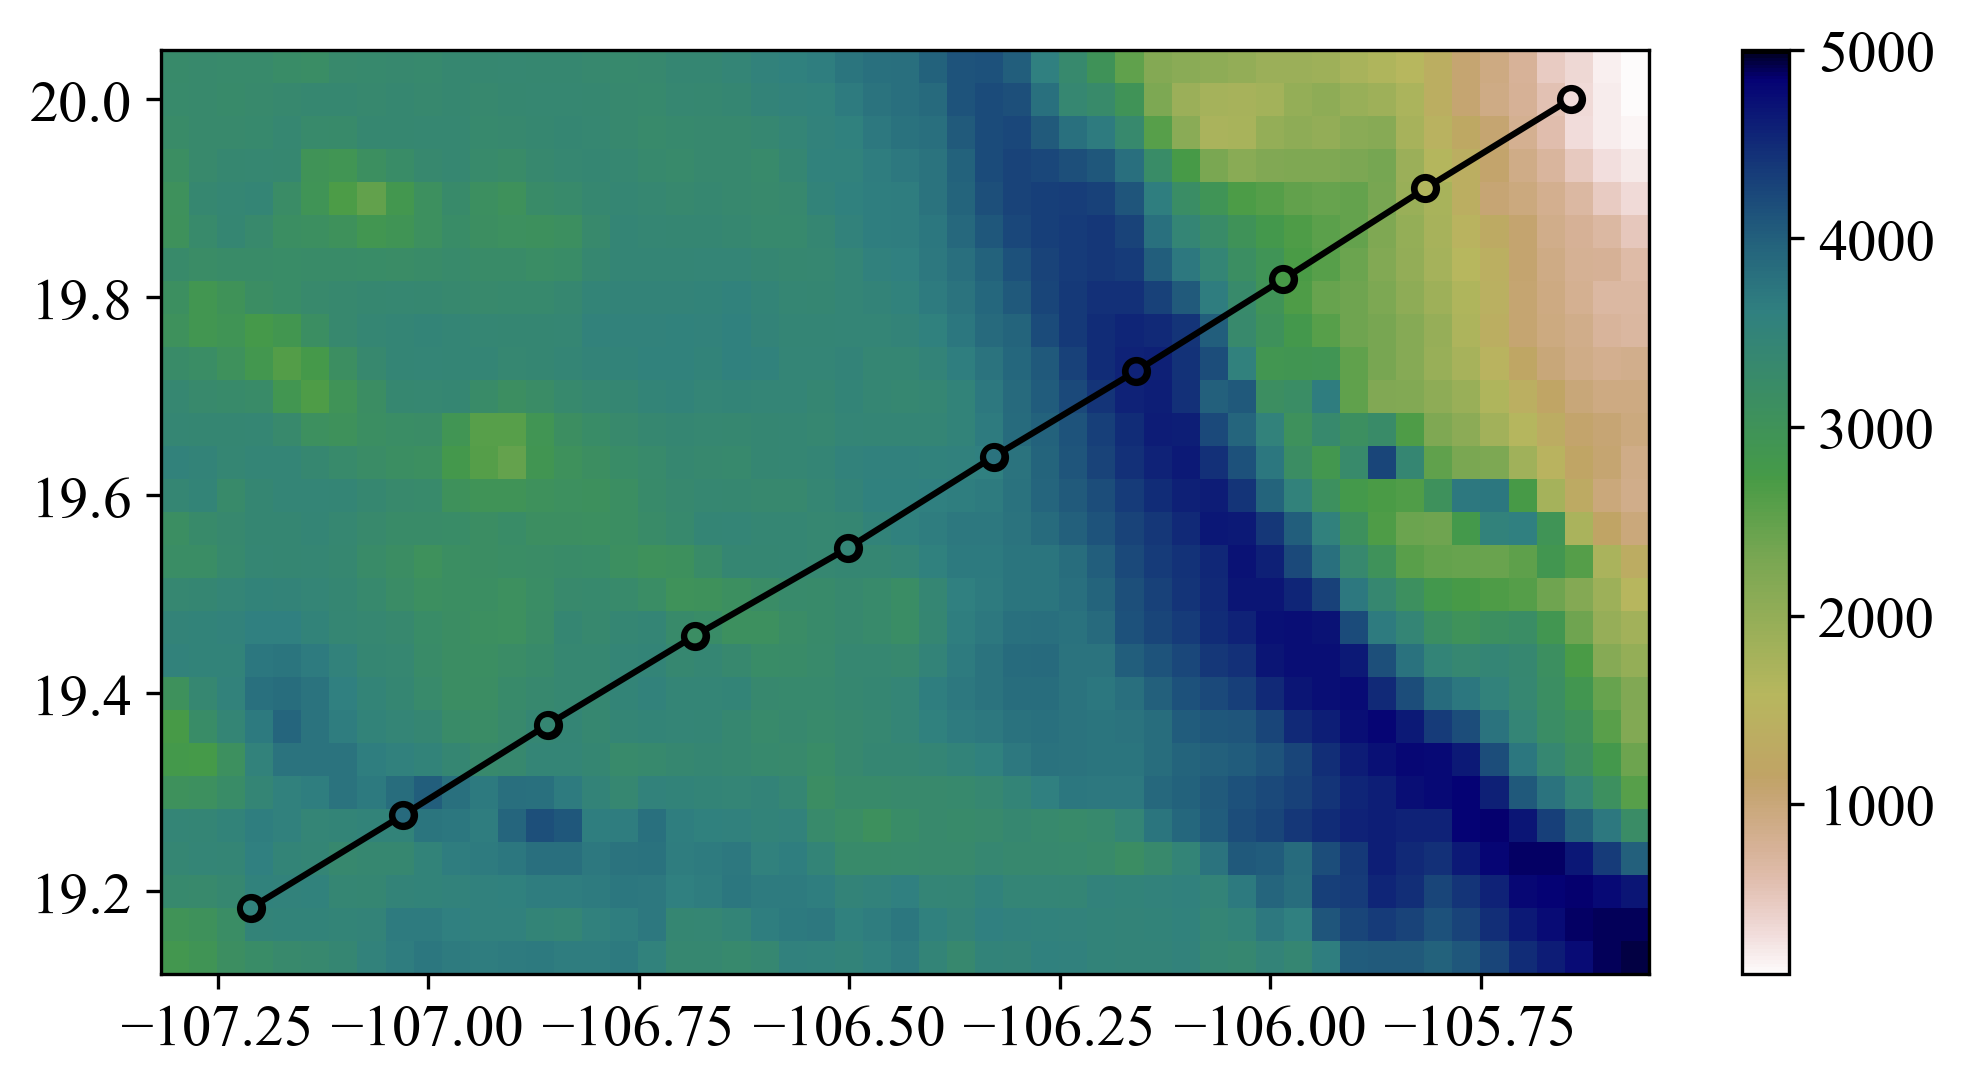

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6418c00f10>

In [19]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
pcm = ax.pcolormesh(bx, by, b', vmin=100., vmax=5000., cmap=plt.cm.gist_earth_r)
ax.plot(lon_u, lat_u, "ko-", zorder=3)
ax.scatter(lon_u, lat_u, s=7, c=depth_interp, vmin=100., vmax=5000., 
    cmap=plt.cm.gist_earth_r, zorder=4)
plt.colorbar(pcm)

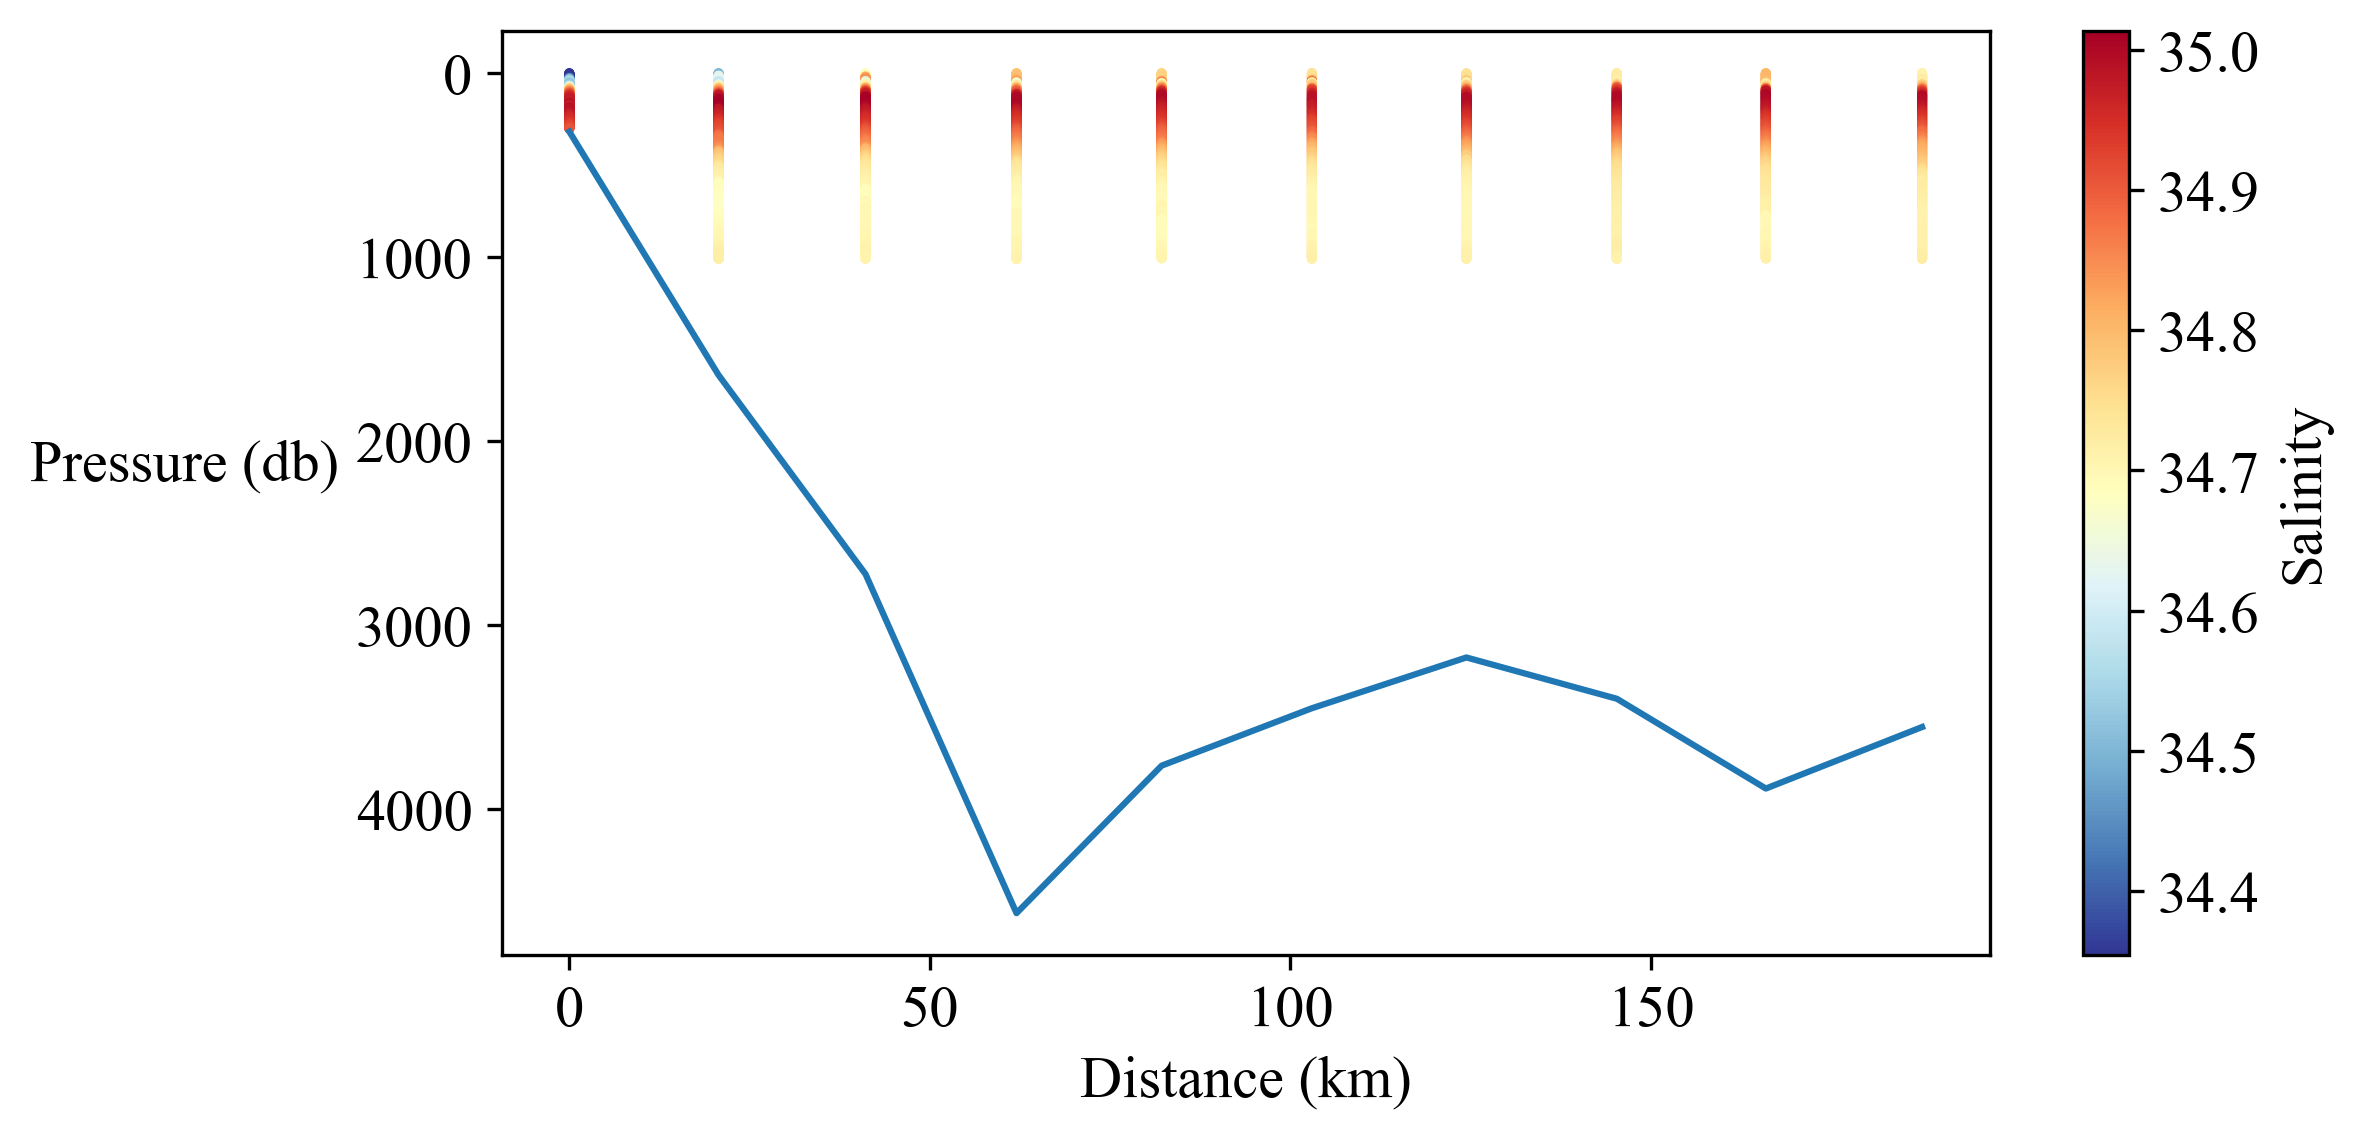

In [21]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
scat = ax.scatter(dist, pres, s=2, c=S, cmap=PyPlot.cm.RdYlBu_r)
cb = plt.colorbar(scat)
cb.set_label("Salinity")
ax.plot(unique(dist), depth_interp)
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Pressure (db)", rotation=0, ha="right")
plt.gca().invert_yaxis()

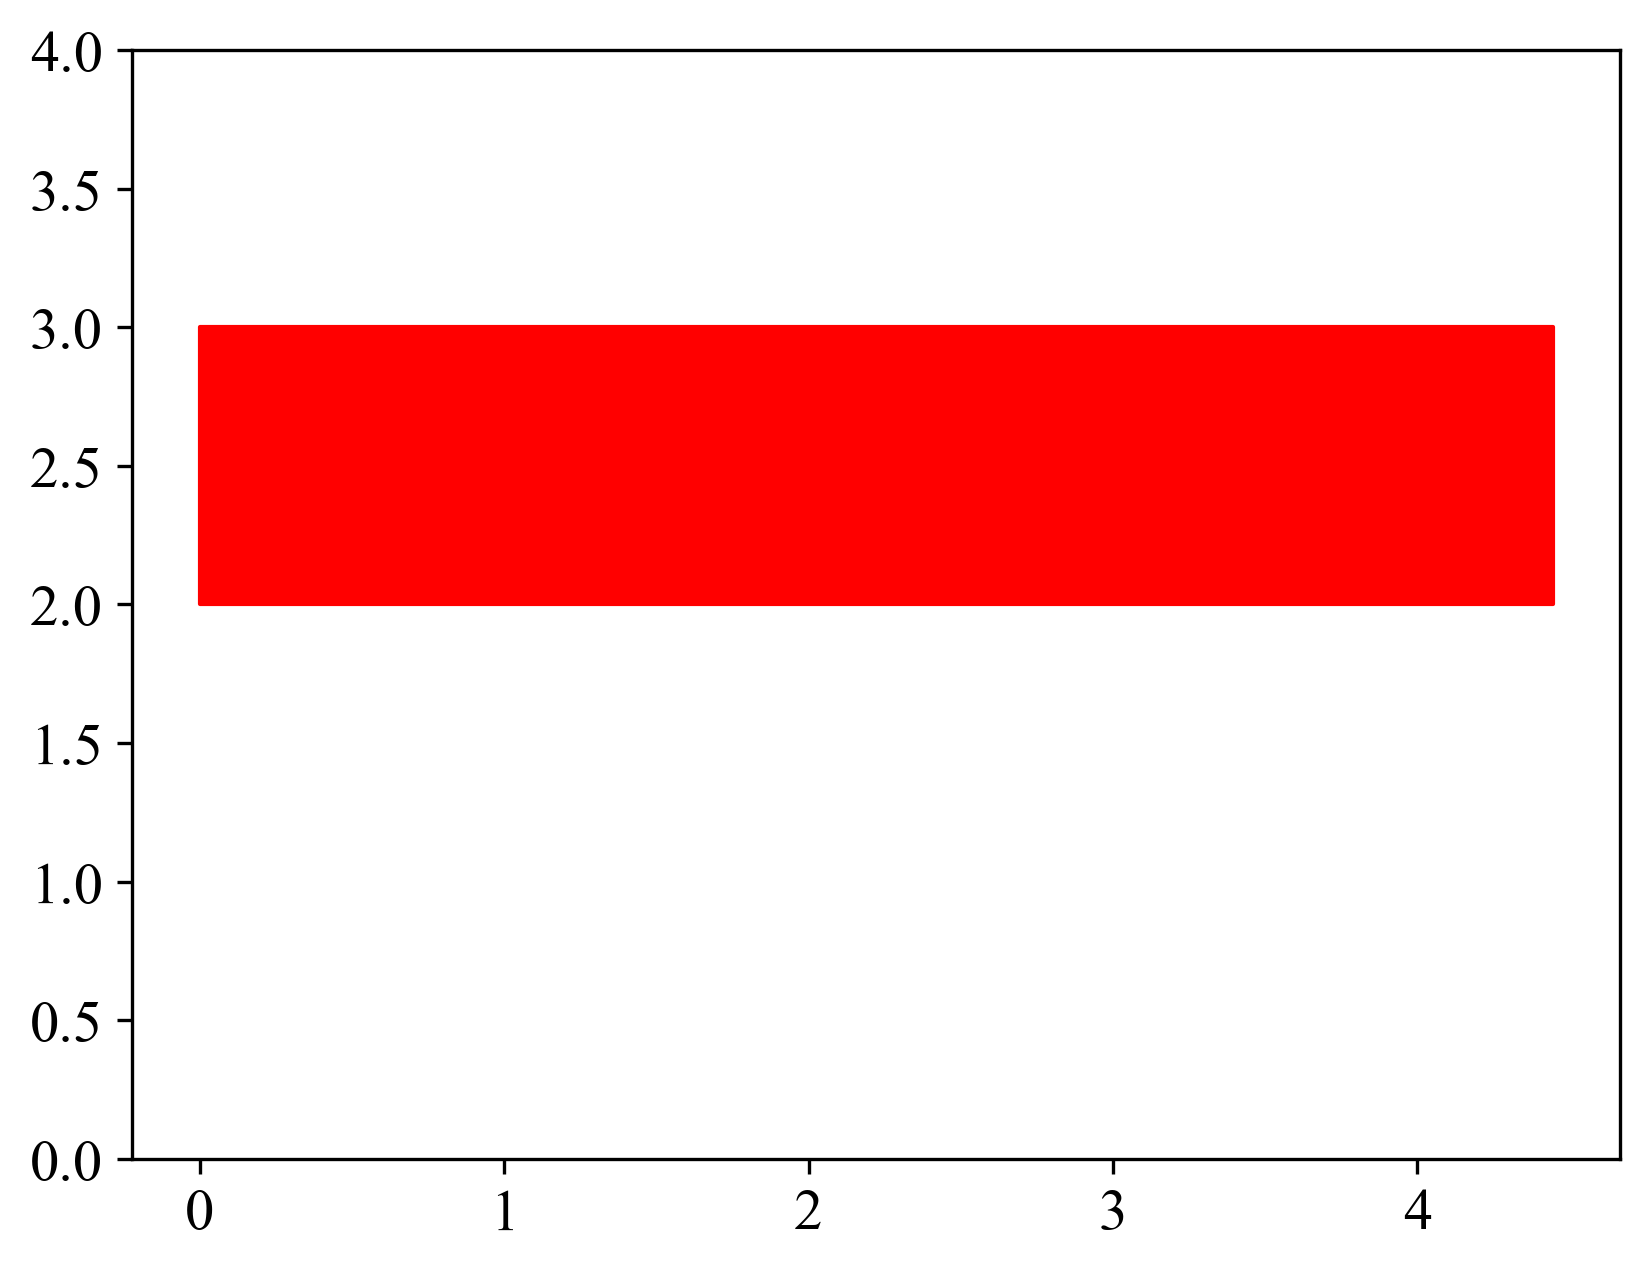

(0, 4)

In [28]:
plt.fill_betweenx([2., 3.], [0], [4.4444], color="r")
plt.ylim(0, 4)

## Create interpolation grid

In [30]:
Δd = 1. # km
Δh = 1. # meter
distgrid = collect(0.0:Δd:ceil(maximum(dist)))
depthgrid = collect(0.0:Δh:ceil(maximum(pres)));

### Land sea mask
First we interpolate the bathymetry on the distance grid.

In [31]:
npoints = length(distgrid)
lon_grid = range(lon[1], lon[end]; length=npoints);
lat_grid = range(lat[1], lat[end]; length=npoints)
depth_interp_grid = itp.(lon_grid, lat_grid);

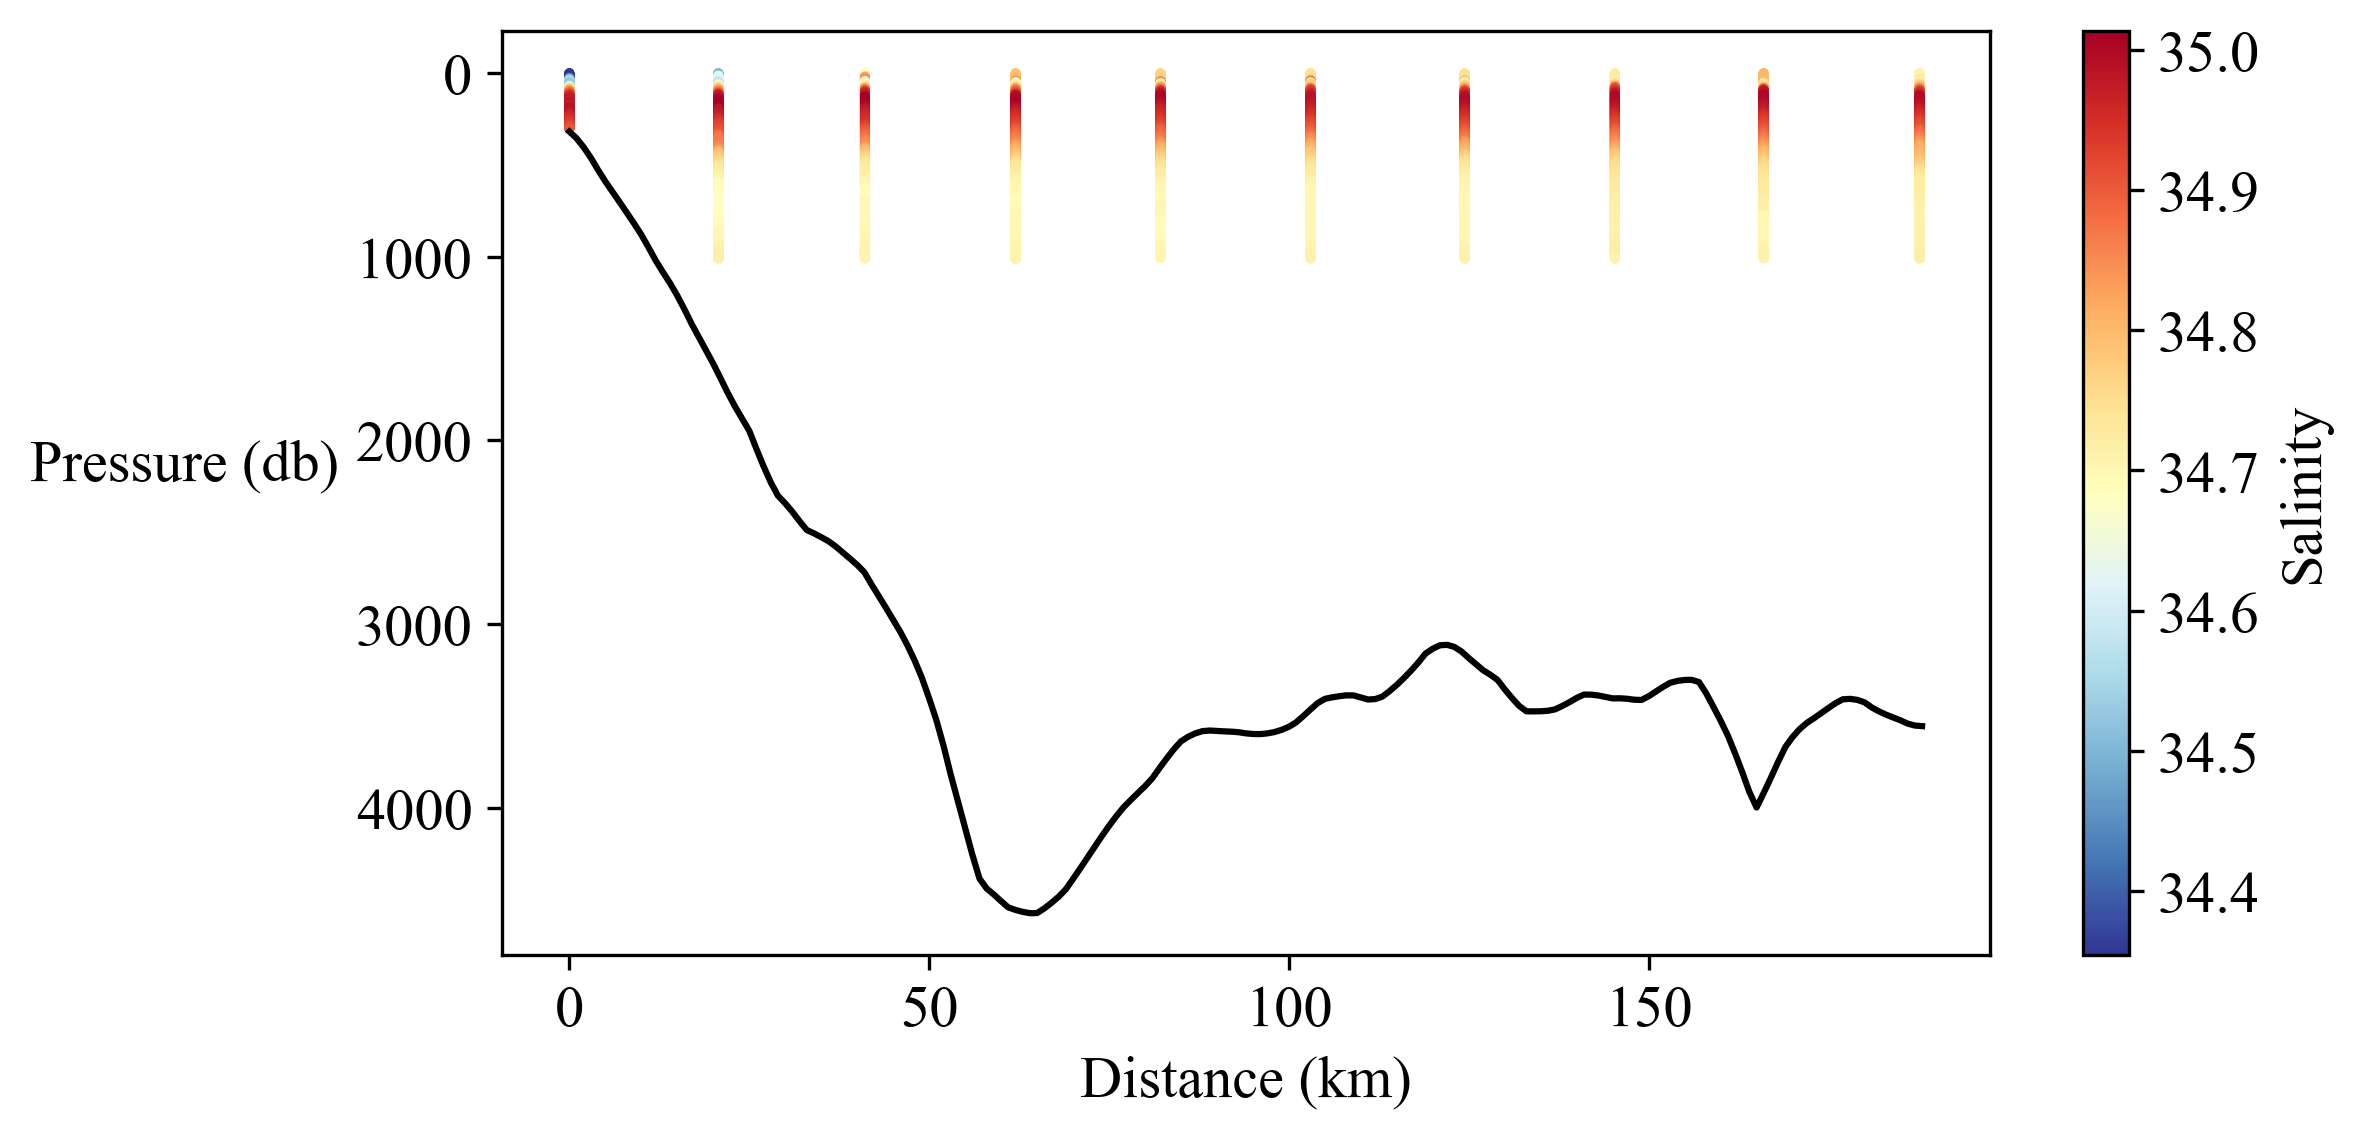

In [34]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
scat = ax.scatter(dist, pres, s=2, c=S, cmap=PyPlot.cm.RdYlBu_r)
cb = plt.colorbar(scat)
cb.set_label("Salinity")
ax.plot(distgrid, depth_interp_grid, "k")
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Pressure (db)", rotation=0, ha="right")
plt.gca().invert_yaxis()

Then we can construct the mask.

In [35]:
mask = falses(length(distgrid), length(depthgrid));
for (ii, d) in enumerate(distgrid)
    for (jj, h) in enumerate(depthgrid)
        if h < depth_interp_grid[ii]
            mask[ii, jj] = true
        end
    end
end;

## Analysis
### Create metrics

In [36]:
mask_rect, pmn, xyi = DIVAnd_rectdom(distgrid, depthgrid);

### Set parameters

In [37]:
len = (15.0 .* ones(length(distgrid), length(depthgrid)), 
        5.0 .* ones(length(distgrid), length(depthgrid))) # km, meters
epsilon2 = 5.

5.0

### Run analysis
We remove the mean value to get the anomalies.
#### Salinity

In [38]:
Sinterp, S_struct = DIVAndrun(mask_rect, pmn, xyi, (dist, pres), S .- mean(S), 
    len, epsilon2, alphabc=0);

In [ ]:
Smin, Smax = 34.3, 35.
PyPlot.pcolormesh(distgrid, depthgrid, Sinterp' .+ mean(S), 
    vmin=Smin, vmax=Smax, cmap=PyPlot.cm.RdYlBu_r)
PyPlot.scatter(dist, pres, s=1, c=S, 
    vmin=Smin, vmax=Smax, cmap=PyPlot.cm.RdYlBu_r)
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.colorbar()
PyPlot.gca().invert_yaxis()

#### Oxygen

In [ ]:
Oxyinterp, Oxy_struct = DIVAndrun(mask_rect, pmn, xyi, (dist, pres), oxy .- mean(oxy), 
    len, epsilon2, alphabc=0);

In [ ]:
oxymin, oxymax = 0., 200.
pcm = PyPlot.pcolormesh(distgrid, depthgrid, Oxyinterp' .+ mean(oxy), 
    vmin=oxymin, vmax=oxymax)
PyPlot.scatter(dist, pres, s=1, c=oxy, 
    vmin=oxymin, vmax=oxymax)
cb = PyPlot.colorbar(pcm)
cb.set_label("Oxygen concentration")
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.gca().invert_yaxis()